# Assignment 5 - Reinforcement Learning

## *Shiwen Chen*
Netid:  *sc538*

### Blackjack

Your goal is to develop a reinforcement learning technique to learn the optimal policy for winning at blackjack. Here, we're going to modify the rules from traditional blackjack a bit in a way that corresponds to the game presented in Sutton and Barto's *Reinforcement Learning: An Introduction* (Chapter 5, example 5.1). A full implementation of the game is provided and usage examples are detailed in the class header below.

The rules of this modified version of the game of blackjack are as follows:

- Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  We're playing against a fixed (autonomous) dealer.
- Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and we're refer to it as 'usable' at 11 (indicating that it could be used as a '1' if need be. This game is placed with a deck of cards sampled with replacement.
- The game starts with each (player and dealer) having one face up and one face down card.
- The player can request additional cards (hit, or action '1') until they decide to stop (stay, action '0') or exceed 21 (bust, the game ends and player loses).
- After the player stays, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.



You will accomplish three things:
1. Try your hand at this game of blackjack and see what your human reinforcement learning system is able to achieve
2. Evaluate a simple policy using Monte Carlo policy evaluation
3. Determine an optimal policy using Monte Carlo control

*This problem is adapted from David Silver's [excellent series on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) at University College London*

## 1

### [10 points] Human reinforcement learning 

Using the code detailed below, play 50 hands of blackjack, and record your overall average reward. This will help you get accustomed with how the game works, the data structures involved with representing states, and what strategies are most effective.

In [1]:
import numpy as np

class Blackjack():
    """Simple blackjack environment adapted from OpenAI Gym:
        https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with a deck sampled with replacement.
    
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit = 1) until they decide to stop
    (stay = 0) or exceed 21 (bust).
    
    After the player stays, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).
    
    http://incompleteideas.net/sutton/book/the-book.html
    
    Usage: 
        Initialize the class:
            game = Blackjack()
        
        Deal the cards:
            game.deal()
            
             (14, 3, False)
             
            This is the agent's observation of the state of the game:
            The first value is the sum of cards in your hand (14 in this case)
            The second is the visible card in the dealer's hand (3 in this case)
            The Boolean is a flag (False in this case) to indicate whether or 
                not you have a usable Ace
            (Note: if you have a usable ace, the sum will treat the ace as a 
                value of '11' - this is the case if this Boolean flag is "true")
            
        Take an action: Hit (1) or stay (0)
        
            Take a hit: game.step(1)
            To Stay:    game.step(0)
            
        The output summarizes the game status:
            
            ((15, 3, False), 0, False)
            
            The first tuple (15, 3, False), is the agent's observation of the
            state of the game as described above.
            The second value (0) indicates the rewards
            The third value (False) indicates whether the game is finished
    """
    
    def __init__(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.dealer = []
        self.player = []
        self.deal()

    def step(self, action):
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stay: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
        return self._get_obs(), reward, done

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def deal(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()
    
    #------------------------------------------
    # Other helper functions
    #------------------------------------------
    def cmp(self, a, b):
        return float(a > b) - float(a < b)
    
    def draw_card(self):
        return int(np.random.choice(self.deck))
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    def usable_ace(self,hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21
    
    def sum_hand(self,hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)
    
    def is_bust(self,hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self,hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

Here's an example of how it works to get you started:

In [180]:
import numpy as np

# Initialize the class:
game = Blackjack()

# Deal the cards:
s0 = game.deal()
print(s0)

# Take an action: Hit = 1 or stay = 0. Here's a hit:
s1 = game.step(1)
print(s1)

# If you wanted to stay:
# game.step(2)

# When it's gameover, just redeal:
# game.deal()

(21, 5, True)
((21, 5, False), 0, False)


**ANSWER**

In [3]:
result = []

In [148]:
#start
game = Blackjack()
s0 = game.deal()
print(s0)

(6, 1, False)


In [149]:
#hit
s_h = game.step(1)
print(s_h)
#record result
if s_h[2] == True:
    result.append(s_h[1])

((16, 1, False), 0, False)


In [150]:
#stay
s_s = game.step(0)
print(s_s)
#record result
result.append(s_s[1])

((16, 1, False), -1.0, True)


In [158]:
print("Results:", result)
print("Overall average reward:", np.mean(result))

Results: [-1.0, 1.0, -1.0, 0.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, -1.0, -1, 1.0, 1.0, -1, -1.0, 1.0, 1.0, 1.0, -1, -1.0, -1, 0.0, 1.0, 1.0, -1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1, -1, -1.0, -1, -1.0]
Overall average reward: 0.12


## 2

### [40 points] Perform Monte Carlo Policy Evaluation

Thinking that you want to make your millions playing blackjack, you decide to test out a policy for playing this game. Your idea is an aggressive strategy: always hit unless the total of your cards adds up to 20 or 21, in which case you stay.

**(a)** Use Monte Carlo policy evaluation to evaluate the expected returns from each state. Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected returns for each state. In this case create 2 plots:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's card). Do this for for 10,000 episodes.
2. Repeat (1) for the states without a usable ace.
3. Repeat (1) for the case of 500,000 episodes.
4. Relwat (2) for the case of 500,000 episodes.

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. For both the 10,000 episode case and the 500,000 episode case, record the overall average reward for this policy and report that value. 

**ANSWER**

In [196]:
def naive_policy(s): #hit if <20
    if type(s[0])==int: #for newly dealed deck
        if s[0]>19: 
            s = game.step(0)
        else: 
            s = game.step(1)
    else: #for hit deck
        if s[0][0]>19: 
            s = game.step(0)
        else: 
            s = game.step(1)
    return s

In [402]:
def get_state_value(loop):
    v0 = np.zeros((2,10,20)) #v0[0/1 whether have useable ace, dealer, player]
    v0_count = np.zeros((2,10,20))
    for i in range(loop):
        hist = [] #history
        s = game.deal() #generate an episode
        ace = s[2]*1
        dealer = s[1]
        player = s[0]
        while True:
            hist.append((ace,dealer,player))
            v0_count[ace,dealer-1,player-2] += 1
            s = naive_policy(s)
            if s[2]: #if ended 
                for i in range(len(hist)): #update v0
                    t = len(hist)-i-1
                    ace = hist[t][0]
                    dealer = hist[t][1]
                    player = hist[t][2]
                    count = v0_count[ace,dealer-1,player-2]
                    v0[ace,dealer-1,player-2] = (v0[ace,dealer-1,player-2]*(count-1) + s[1])/count
                break
            ace = s[0][2]*1
            dealer = s[0][1]
            player = s[0][0]
    return v0

In [404]:
game = Blackjack()
v0_1=get_state_value(10000)
v0_2=get_state_value(500000)

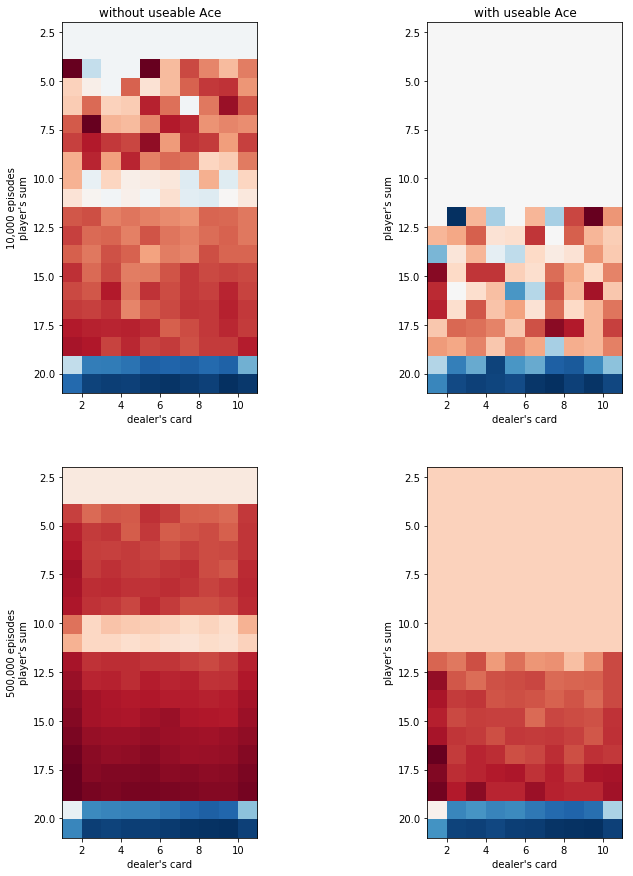

In [405]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,15))
plt.subplot(2,2,1)
plt.imshow(v0_1[0].T,cmap='RdBu',extent=[1,11,21,2])
plt.xlabel("dealer's card")
plt.ylabel("10,000 episodes\nplayer's sum")
plt.title("state value without useable Ace")
plt.subplot(2,2,2)
plt.imshow(v0_1[1].T,cmap='RdBu',extent=[1,11,21,2])
plt.xlabel("dealer's card")
plt.ylabel("player's sum")
plt.title("state value with useable Ace")
plt.subplot(2,2,3)
plt.imshow(v0_2[0].T,cmap='RdBu',extent=[1,11,21,2])
plt.xlabel("dealer's card")
plt.ylabel("500,000 episodes\nplayer's sum")
plt.subplot(2,2,4)
plt.imshow(v0_2[1].T,cmap='RdBu',extent=[1,11,21,2])
plt.xlabel("dealer's card")
plt.ylabel("player's sum")
plt.show()

In [320]:
results = []
for i in range(500000):
    s = game.deal()
    while True:
        s = naive_policy(s)
        if s[2]: #if ended
            results.append(s[1])
            break

In [342]:
avg_reward = []
avg_reward.append(results[0])
for i in range(499999):
    avg_reward.append((avg_reward[i]*(i+1)+results[i+1])/(i+2))

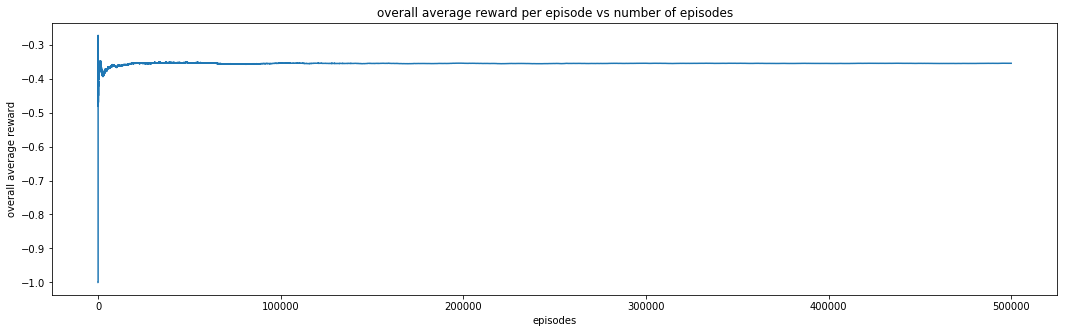

overall average reward for 10,000 episodes:-0.37,
for 500,000 episodes:-0.35


In [353]:
plt.figure(figsize=(18,5))
plt.plot(avg_reward)
plt.title("overall average reward per episode vs number of episodes")
plt.xlabel("episodes")
plt.ylabel("overall average reward")
plt.show()
print("overall average reward for 10,000 episodes:{:.2f},\nfor 500,000 episodes:{:.2f}"
      .format(avg_reward[9999],avg_reward[499999]))

## 3

### [40 points] Perform Monte Carlo Control

**(a)** Using Monte Carlo Control through policy iteration, estimate the optimal policy for playing our modified blackjack game to maximize rewards. 

In doing this, use the following assumptions:
1. Initialize the value function and the state value function to all zeros
2. Keep a running tally of the number of times the agent visited each state and chose an action. $N(s_t,a_t)$ is the number of times action $a$ has been selected from state $s$. You'll need this to compute the running average. You can implement an online average as: $\bar{x}_{t} = \frac{1}{N}x_t + \frac{N-1}{N}\bar{x}_{t-1}$ 
3. Use an $\epsilon$-greedy exploration strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where we define $N_0 = 100$. Vary $N_0$ as needed.

Show your result by plotting the optimal value function: $V^*(s) = max_a Q^*(s,a)$ and the optimal policy $\pi^*(s)$. Create plots for these similar to Sutton and Barto, Figure 5.2 in the new draft edition, or 5.5 in the original edition. Your results SHOULD be very similar to the plots in that text. For these plots include:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's visible card).
2. Repeat (1) for the states without a usable ace.
3. A plot of the optimal policy $\pi^*(s)$ for the states with a usable ace (this plot could be an imshow plot with binary values).
4. A plot of the optimal policy $\pi^*(s)$ for the states without a usable ace (this plot could be an imshow plot with binary values).

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. What is the average reward your control strategy was able to achieve?

*Note: convergence of this algorithm is extremely slow. You may need to let this run a few million episodes before the policy starts to converge. You're not expected to get EXACTLY the optimal policy, but it should be visibly close.* 

**ANSWER**

In [446]:
class mc_control:
    def __init__(self): # intitalize value function
        self.q = np.zeros((2,10,20,2)) #action value function, 0 is hold, 1 is hit 
        #self.v = np.zeros((2,10,20)) #state value function
        self.n = np.zeros((2,10,20,2)) #number of times action a selected

    def ep_greedy(self,ace,dealer,player): #choose action according to state
        n0 = 100
        nt = sum(self.n[ace,dealer-1,player-2,:])
        ep = n0/(n0+nt)
        if np.random.random() < 1 - ep: #choose a* with probability 1 − ep
            a = np.argmax(self.q[ace,dealer-1,player-2,:])
        else: # random pick
            a = 1
            if np.random.random() >= 0.5: a = 0
        return a
    
    def policy_eval(self,loop):
        game = Blackjack()
        for i in range(loop):
            hist = [] #history
            s = game.deal()
            ace = s[2]*1
            dealer = s[1]
            player = s[0]
            while True:
                action = self.ep_greedy(ace,dealer,player) #get action
                hist.append((ace,dealer,player,action))
                self.n[ace,dealer-1,player-2,action] += 1
                s = game.step(action)
                if s[2]: #if ended 
                    for i in range(len(hist)): #update v0
                        t = len(hist)-i-1
                        ace = hist[t][0]
                        dealer = hist[t][1]
                        player = hist[t][2]
                        action = hist[t][3]
                        count = self.n[ace,dealer-1,player-2,action]
                        #count_v = sum(self.n[ace,dealer-1,player-2,:])
                        #self.v[ace,dealer-1,player-2] = (self.v[ace,dealer-1,player-2]*(count_v-1) + s[1])/count_v
                        self.q[ace,dealer-1,player-2,action] = (self.q[ace,dealer-1,player-2,action]*(count-1) + s[1])/count
                    break
                ace = s[0][2]*1
                dealer = s[0][1]
                player = s[0][0]
        return self.q, self.n

In [492]:
mc = mc_control()
q, n = mc.policy_eval(2000000)

In [516]:
nt = np.sum(n,axis=3)
opt_policy = np.argmax(q,axis=3) #greedy policy
policy = np.subtract(opt_policy,2*(nt==0)) #negative value for N/A points
v = np.max(q,axis=3)


State value:


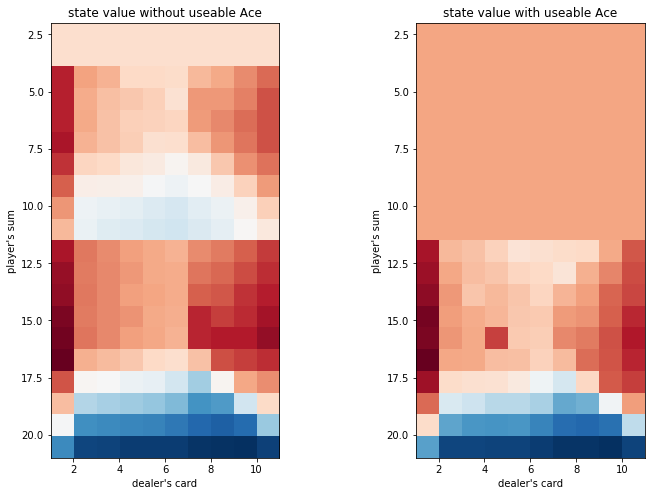

Optimal Policy:


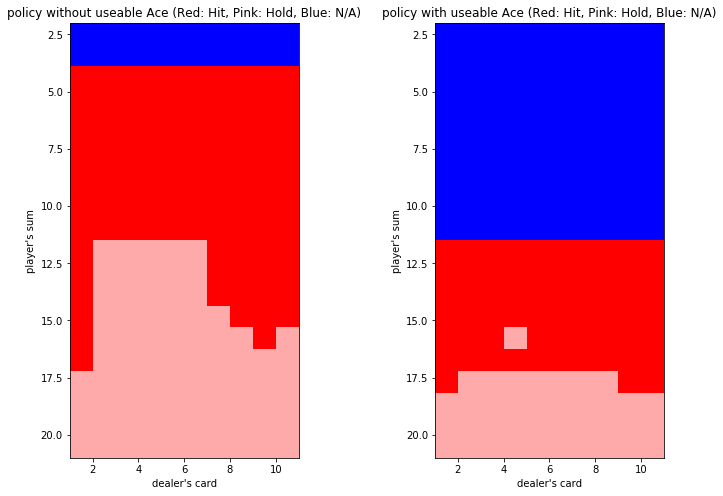

In [517]:
print("\nState value:")
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(v[0].T,cmap='RdBu',extent=[1,11,21,2])
plt.xlabel("dealer's card")
plt.ylabel("player's sum")
plt.title("state value without useable Ace")
plt.subplot(1,2,2)
plt.imshow(v[1].T,cmap='RdBu',extent=[1,11,21,2])
plt.xlabel("dealer's card")
plt.ylabel("player's sum")
plt.title("state value with useable Ace")
plt.show()
print("Optimal Policy:")
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(policy[0].T,cmap='bwr',extent=[1,11,21,2])
plt.xlabel("dealer's card")
plt.ylabel("player's sum")
plt.title("policy without useable Ace (Red: Hit, Pink: Hold, Blue: N/A)")
plt.subplot(1,2,2)
plt.imshow(policy[1].T,cmap='bwr',extent=[1,11,21,2])
plt.xlabel("dealer's card")
plt.ylabel("player's sum")
plt.title("policy with useable Ace (Red: Hit, Pink: Hold, Blue: N/A)")
plt.show()

In [521]:
results = []
for i in range(100000):
    s = game.deal()
    ace = s[2]*1
    dealer = s[1]
    player = s[0]
    while True:
        action = opt_policy[ace,dealer-1,player-2]
        s = game.step(action)
        if s[2]:
            results.append(s[1])
            break
        ace = s[0][2]*1
        dealer = s[0][1]
        player = s[0][0]

In [522]:
avg_reward = []
avg_reward.append(results[0])
for i in range(99999):
    avg_reward.append((avg_reward[i]*(i+1)+results[i+1])/(i+2))

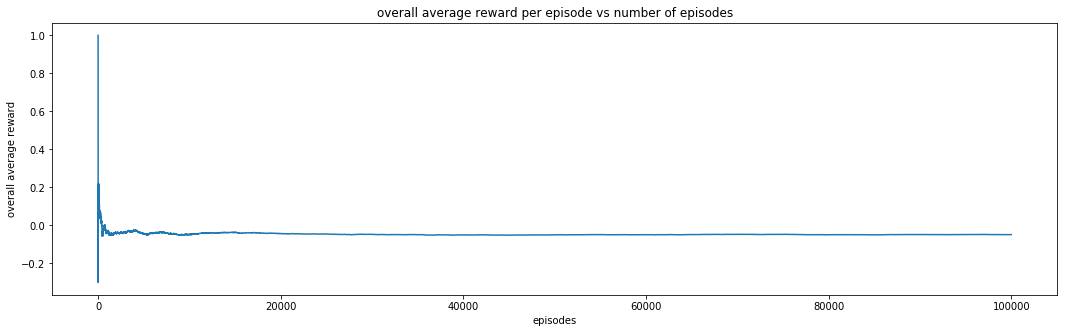

overall average reward for 50 episodes:0.20,
for 100,000 episodes:-0.05


In [525]:
plt.figure(figsize=(18,5))
plt.plot(avg_reward)
plt.title("overall average reward per episode vs number of episodes")
plt.xlabel("episodes")
plt.ylabel("overall average reward")
plt.show()
print("overall average reward for 50 episodes:{:.2f},\nfor 100,000 episodes:{:.2f}"
      .format(avg_reward[49],avg_reward[99999]))

## 4

### [10 points] Discuss your findings

Compare the performance of your human control policy, the naive policy from question 2, and the optimal control policy in question 3. 
**(a)** Which performs best? Why is this the case? 
**(b)** Could you have created a better policy if you knew the full Markov Decision Process for this environment? Why or why not?

**ANSWER**

By comparing the 3 approaches, we find that the overall average reward of optimal control policy (-0.05) is higher than that of the naive policy (-0.35). The performance of human control seems higher than both (0.12), but it can be caused by the small number of episode (50). We can see that the average reward by control policy is also high at 50 episodes (0.20) but dropped and stablized at -0.05.

The control policy is better than the naive policy because instead of sticking with one policy, it improves policy according to the expected return of each action. It also has a more flexible decision boundary that better represents the true optimal decision. The policy concluded from Monte Carlo control is actually similar to the human control policy, therefore the performance can also be similar.

If we have full knowledge about the Markov Decision Process, we can develop a better policy. Because through the iteration in question 3, we are exploring both the MDP and the policy at the same time. Therefore, policies are constantly dervied from a estimate version of the environment, making it worse than the one derived from perfect MDP. However, if the number of interation is large enough that we have a near perfect estimation of the MDP, the performance can be similar.